# Determining reaction coordinates of the linear partcle model fit to the full model
Programmer: Tim Tyree<br>
Date: 8.15.2022

In [610]:
from scipy.optimize import minimize

from lib.my_initialization import *
from lib import *
#from lib.lib_care.measure.level_sets import comp_longest_level_set_and_smooth
%load_ext autoreload
%autoreload 2

import random,scipy
from scipy.interpolate import LinearNDInterpolator
from scipy.interpolate import CloughTocher2DInterpolator
import matplotlib as mpl #for colorbar
from scipy import stats
#DONE: hook this routine up to dask
#DONT: hook this routine up to dask_cuda
# import scanpy as sc
darkmode=False
if darkmode:
    # For darkmode plots
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
#     theme=cuxfilter.themes.dark
#     #     theme=cuxfilter.themes.rapids
else:
    sns.set_style('white')
#     theme=cuxfilter.themes.light
import warnings
warnings.simplefilter("ignore", UserWarning)
%load_ext autoreload
%autoreload 2
# import cupy as cp
np.random.seed(42)
# cp.random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [507]:
#reset matplotlib settings
import matplotlib as mpl
sns.reset_orig()
mpl.rc_file_defaults()

In [508]:
wjr=recall_powerlaw_fits_to_full_models()
print(*wjr)

fk_pbc lr_pbc fk_ncbc lr_ncbc


In [527]:
#apparent measurements
# #FK (a_hat short timescale, D_hat long timescale)
a_hat_FK=7.3923;
D_hat_FK=0.365238#;num_pairs=25;tavg_step=5;tavg1_max=15;tavg2_max=15

a_hat_FK_long = 1.509282#+/-0.178827 cm^2/s, tmax=90
a_hat_FK_vlong = 1.604153#+/-0.040173 cm^2/s
# tavg2=14 ms, num_samples=19087, tmin=0, tmax=300 ms


#msr from the particle model
# npz_dir_FK='/home/timothytyree/Documents/GitHub/bgmc/python/data/control_data/arrays/control_a_7.3923_D_0.365238.npz'#csv'
#msr from the full model
# msr_dir_fk='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/msr_fk_boostrapped_tavg2_14.0_n_19087_a_1.6_tmax_300.csv'

#LR (a_hat short timescale, D_hat long timescale)
a_hat_LR=8.595
D_hat_LR=0.586055#;num_pairs=25;tavg_step=5;tavg1_max=15;tavg2_max=15
#msr from the particle model
# npz_dir_LR='/home/timothytyree/Documents/GitHub/bgmc/python/data/control_data/arrays/control_a_8.595_D_0.586055.npz'#.csv'
a_hat_LR_long = 3.535902#+/-0.312245 cm^2/s, tmax=60

# define module

In [533]:
def comp_rmse_powerlaw(df,M,m,dq=0.05,q_values=None):
    """
    Example Usage:
input_fn=f"/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_24_all_powerlaw_fits.csv"
df=pd.read_csv(input_fn)
df = comp_rmse_powerlaw(df,q_values,M,m,dq=0.05)
df.sort_values(by='rmse',inplace=True)
df['rmse'].values
    """
    if q_values is None:
        #compute q_values used by df
        q_min = df.q_min.drop_duplicates().values[0]
        q_max = df.q_max.drop_duplicates().values[0]
        q_values=np.arange(q_min,q_max,dq)
        
    #input: m,M, q_values used by df
    #output: w_values
    w_values=M*q_values**m

    #compute rmse for each row
    df['rmse']=np.nan
    for i,row in df.iterrows():
        m_ = row['m']
        M_ = row['M']
        w_values_linear=M_*q_values**m_
        df.loc[i,'rmse']= np.sqrt(np.mean((w_values_linear-w_values)**2))
    return df

# visualize 2D scatter plot at constant a,D with diverging color map centered at a desired powerlaw fit

In [716]:
# input_fn=f"{nb_dir}/data/osg_output/run_15_all_powerlaw_fits.csv"
# input_fn=f"{nb_dir}/data/osg_output/run_16_all_powerlaw_fits.csv"
# input_fn=f"{nb_dir}/data/osg_output/run_17_all_powerlaw_fits.csv"
# input_fn=f"{nb_dir}/data/osg_output/run_18_all_powerlaw_fits.csv"
# input_fn=f"{nb_dir}/data/osg_output/run_19_all_powerlaw_fits.csv"
# input_fn=f"{nb_dir}/data/osg_output/run_20_all_powerlaw_fits.csv"#too low varkappa
# input_fn=f"{nb_dir}/data/osg_output/run_21_all_powerlaw_fits.csv"#too low varkappa
# input_fn=f"{nb_dir}/data/osg_output/run_22_all_powerlaw_fits.csv" #too low varkappa #min m: 1.0
# input_fn=f"{nb_dir}/data/osg_output/run_23_all_powerlaw_fits.csv" #too low varkappa
# input_fn=f"{nb_dir}/data/osg_output/run_24_all_powerlaw_fits.csv"
input_fn=f"{nb_dir}/data/osg_output/run_25_all_powerlaw_fits.csv"

# # #run 24, 25  #Rsq min is 0.89 before filtering...
# input_fn='/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/powerlaw_fits_aggregated_neighbor_1_numobs_21879.csv'

df=pd.read_csv(input_fn)

print(f"parameter range:")
print(df.describe()[['varkappa','D','L','r','kappa','M','m']].T[['min','max']].T)
print(f"\nalinear values considered: {sorted(df['varkappa'].drop_duplicates().values)} cm^2/s")
# print(f"\n\n(more details:)")
# print(df.describe().T[['min','max']])

parameter range:
     varkappa      D    L     r  kappa           M         m
min     1.553  0.090  5.0  0.01  100.0    1.607750  1.373735
max     9.969  0.114  5.0  0.49  990.0  516.569239  5.470393

alinear values considered: [1.553, 9.969] cm^2/s


In [705]:
df.force_code.drop_duplicates()

0    2
Name: force_code, dtype: int64

In [681]:
#define constant parameters
reflect=0
force_code=2
set_second=0
no_attraction=0
no_repulsion=0
# kappa=100
# L=10
L=5
testing=False #True yields an extra runtimme of ~2 minutes

In [682]:
# #neighbor-only forces
# input_fn=f"/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_19_all_powerlaw_fits.csv"
neighbor=1
# vector-summed forces
# input_fn=f"/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_17_all_powerlaw_fits.csv"
# input_fn=f"{nb_dir}/data/osg_output/run_17_all_powerlaw_fits.csv"
# neighbor=0

#TODO: aggregate powerlaw fits with neighbor-only or vector-summed fits 
#TODO: aggregate powerlaw fits with D>=1.2


df=pd.read_csv(input_fn)
#query the DataFrame
query =(df.set_second==set_second)&(df.reflect==reflect)
query&=(df.no_repulsion==no_repulsion)&(df.no_attraction==no_attraction)
query&=(df.neighbor==neighbor)&(df.force_code==force_code)
# query&=df.r==r
# query&=df.kappa==kappa
# query&=df.D==D
query&=df.L==L
# query&=df.varkappa==varkappa
dg=df[query]
dg.shape

(17640, 24)

## brain-warmer: basic scatter plot

In [683]:
dg['varkappa'].drop_duplicates().values

array([1.553, 9.969])

In [684]:
dg['D'].drop_duplicates().values

array([0.09 , 0.114])

In [685]:
df.m.min()

1.3737352852879994

In [690]:
# #FK 200x200, diffCoeff=0.001
# # src: TT
# alinear=1.12
# D=.365
# # src: wjr
# M=5.57# +/- (30)
# nu=1.877# +/- (25)
# L=5

# #didn't work...
# #LR 200x200, diffCoeff=0.0005
# # src: TT
# alinear=2.76 
# D=0.58
# # src: wjr
# M=16.73# +/- (84)
# nu=1.638# +/- (17)
# L=5

#TODO: fix interp_magnitude(x1,x2,x3,x4) to an observed value from the full model

# #FK 200x200, diffCoeff=0.0005, src: WJ
# alinear=1.553
# D=0.114
# # M=2.7 # +/- (1.3) #hmean, my measurement
# # nu=0.84 # +/- (17)#hmean, my measurement
# L=5

# M=5.57#5.807  #   #hmean?, wj's measurement
# nu=1.877 #   #hmean?, wj's measurement

#LR 200x200, diffCoeff=0.001, src: WJ
alinear=9.969
D=0.09
M=12.6 # +/- (3.8)  #hmean, my measurement
nu=1.20 # +/- (8)   #hmean, my measurement
L=5

M=16.73#19.62  #   #hmean?, wj's measurement
nu=1.638 #   #hmean?, wj's measurement

In [691]:
print(f"{alinear=}, {D=} ({L=})")
print(f"{M=:.4}, {nu=:.4f}")

alinear=9.969, D=0.09 (L=5)
M=16.73, nu=1.6380


In [692]:
#select by a,D
dh=dg[(dg['varkappa']==alinear)&(dg['D']==D)]
dh.describe().T[['min','max']]
x_values = dh['r'].values/dh['L'].values
y_values = 1/dh['kappa'].values
dh.shape

(4410, 24)

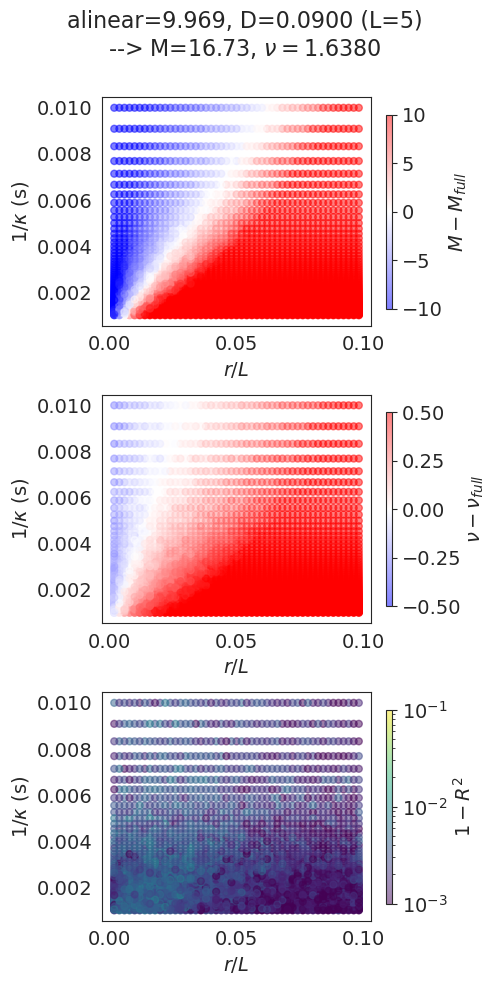

In [693]:
xlabel=r'$r/L$'
# ylabel='$\kappa$ (Hz)'
# ylabel='$1/\kappa$ (s)'
fontsize=14
kwargs_scatter=dict(s=25,alpha=0.5)
title = f"{alinear=:.4}, {D=:.4f} ({L=})\n-->"
title += f" {M=:.4}, "+r"$\nu=$"+f"{nu:.4f}\n"
cmap='bwr'
fontsize=14
fraction=0.07
shrink=0.85
aspect=35

# fig,ax=plt.subplots(ncols=1,figsize=(6,4),constrained_layout=True)
# fig,axs=plt.subplots(ncols=3,figsize=(16,4))
fig,axs=plt.subplots(nrows=3,figsize=(5,10))
ax=axs[0]
c_values=dh['M']-M
cbar_label=r'$M - M_{full}$'
#make diverging color map
norm=mpl.colors.CenteredNorm(vcenter=0, halfrange=10, clip=False)
# c = ax.scatter(x=x_values,y=y_values,c=c_values,**kwargs_scatter)
c = ax.scatter(x=x_values,y=y_values,c=c_values,cmap=cmap,norm=norm,**kwargs_scatter)
#add formated colorbar
cax, kw = mpl.colorbar.make_axes_gridspec(ax, #orientation=orientation,#pad=0.1,
                                       fraction=fraction, shrink=shrink, aspect=aspect)
cbar=fig.colorbar(c, cax=cax,cmap=cmap,norm=norm)#, orientation=orientation)#, extend='max')#, fontsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)
cbar.set_label(label=cbar_label,size=fontsize)
#format_plot
format_plot(ax=ax,xlabel=xlabel,ylabel=ylabel,fontsize=fontsize)

ax=axs[1]
c_values=dh['m']-nu
cbar_label=r'$\nu - \nu_{full}$'
#make diverging color map
norm=mpl.colors.CenteredNorm(vcenter=0, halfrange=.5, clip=False)
# c = ax.scatter(x=x_values,y=y_values,c=c_values,**kwargs_scatter)
c = ax.scatter(x=x_values,y=y_values,c=c_values,cmap=cmap,norm=norm,**kwargs_scatter)
#add formated colorbar
cax, kw = mpl.colorbar.make_axes_gridspec(ax, #orientation=orientation,#pad=0.1,
                                       fraction=fraction, shrink=shrink, aspect=aspect)
cbar=fig.colorbar(c, cax=cax,cmap=cmap,norm=norm)#, orientation=orientation)#, extend='max')#, fontsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)
cbar.set_label(label=cbar_label,size=fontsize)
#format_plot
format_plot(ax=ax,xlabel=xlabel,ylabel=ylabel,fontsize=fontsize)

ax=axs[2]
c_values=1-dh['Rsq']
cbar_label=r'$1-R^2$'

#make color map
vmin=1e-3
vmax=1e-1
norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax)
# c = ax.scatter(x=x_values,y=y_values,c=c_values,**kwargs_scatter)
c = ax.scatter(x=x_values,y=y_values,c=c_values,cmap='viridis',norm=norm,**kwargs_scatter)
#add formated colorbar
cax, kw = mpl.colorbar.make_axes_gridspec(ax, #orientation=orientation,#pad=0.1,
                                       fraction=fraction, shrink=shrink, aspect=aspect)
cbar=fig.colorbar(c, cax=cax,cmap=cmap,norm=norm)#, orientation=orientation)#, extend='max')#, fontsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)
cbar.set_label(label=cbar_label,size=fontsize)
#format_plot
format_plot(ax=ax,xlabel=xlabel,ylabel=ylabel,fontsize=fontsize)
fig.suptitle(title,fontsize=fontsize+2)
plt.tight_layout()
plt.show()

In [666]:
# wjr['fk_pbc']

## plot scatter plots individually

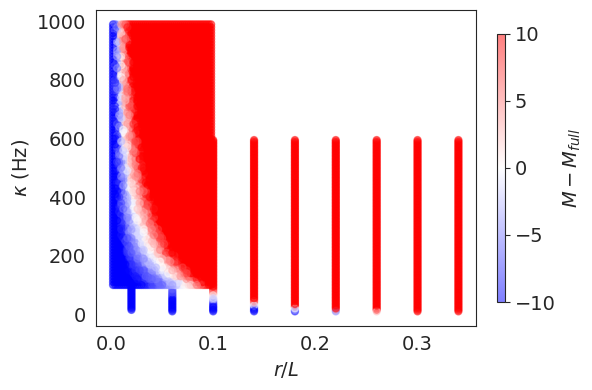

In [620]:
xlabel=r'$r/L$'
ylabel='$\kappa$ (Hz)'
fontsize=14
kwargs_scatter=dict(s=25,alpha=0.5)

# fig,axs=plt.subplots(ncols=3,figsize=(16,4))
# ax=axs[0]
fig,ax=plt.subplots(ncols=1,figsize=(6,4),constrained_layout=True)
c_values=dh['M']-M
cbar_label=r'$M - M_{full}$'

#TODO: make diverging color map
# norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax)
norm=mpl.colors.CenteredNorm(vcenter=0, halfrange=10, clip=False)
cmap='bwr'

# c = ax.scatter(x=x_values,y=y_values,c=c_values,**kwargs_scatter)
c = ax.scatter(x=x_values,y=y_values,c=c_values,cmap=cmap,norm=norm,**kwargs_scatter)


#add formated colorbar
fontsize=14
fraction=0.07
shrink=0.85
aspect=35
# orientation='horizontal'
cax, kw = mpl.colorbar.make_axes_gridspec(ax, #orientation=orientation,#pad=0.1,
                                       fraction=fraction, shrink=shrink, aspect=aspect)
cbar=fig.colorbar(c, cax=cax,cmap=cmap,norm=norm)#, orientation=orientation)#, extend='max')#, fontsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)
cbar.set_label(label=cbar_label,size=fontsize)
#format_plot
format_plot(ax=ax,xlabel=xlabel,ylabel=ylabel,fontsize=fontsize)
plt.tight_layout()
plt.show()

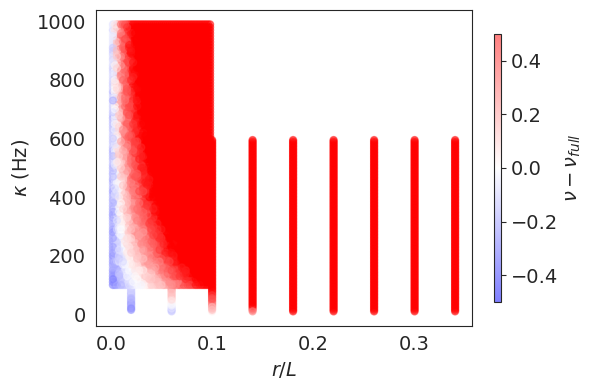

In [624]:
# xlabel=r'$r/L$'
# ylabel='$\kappa$ (Hz)'
# fontsize=14
# kwargs_scatter=dict(s=25,alpha=0.5)

# fig,axs=plt.subplots(ncols=3,figsize=(16,4))
# ax=axs[0]
fig,ax=plt.subplots(ncols=1,figsize=(6,4),constrained_layout=True)
c_values=dh['m']-nu
cbar_label=r'$\nu - \nu_{full}$'

#TODO: make diverging color map
# norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax)
norm=mpl.colors.CenteredNorm(vcenter=0, halfrange=.5, clip=False)
cmap='bwr'
# c = ax.scatter(x=x_values,y=y_values,c=c_values,**kwargs_scatter)
c = ax.scatter(x=x_values,y=y_values,c=c_values,cmap=cmap,norm=norm,**kwargs_scatter)
#add formated colorbar
fontsize=14
fraction=0.07
shrink=0.85
aspect=35
# orientation='horizontal'
cax, kw = mpl.colorbar.make_axes_gridspec(ax, #orientation=orientation,#pad=0.1,
                                       fraction=fraction, shrink=shrink, aspect=aspect)
cbar=fig.colorbar(c, cax=cax,cmap=cmap,norm=norm)#, orientation=orientation)#, extend='max')#, fontsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)
cbar.set_label(label=cbar_label,size=fontsize)
#format_plot
format_plot(ax=ax,xlabel=xlabel,ylabel=ylabel,fontsize=fontsize)
plt.tight_layout()
plt.show()

## TODO(once ^that works): compute 2d interpolation method, as before

In [ ]:
# boo=df['D']==0.1
#extract features X=(r,kappa,varkappa,D) to labels Y=(M,m) as cupy arrays
X_col_lst=['r','kappa']
# X_col_lst=['varkappa','D','r','kappa']
# Y_col_lst=['M','m', 'Delta_M','Delta_m']
Y_col_lst=['M','m', 'Delta_M','Delta_m', 'Rsq']
# Y_col_lst="M"#['M']#,'m', 'Delta_M','Delta_m']
# Xall=dg.loc[boo,X_col_lst].values
# Yall=dg.loc[boo,Y_col_lst].values
Xall=dh[X_col_lst].values
Yall=dh[Y_col_lst].values

In [587]:
dh['M']

3         16.435418
8         13.484952
9        282.413017
10         6.654136
12        64.734869
            ...    
17615      6.624291
17626      3.915031
17629     21.461852
17631      9.720543
17638     48.791260
Name: M, Length: 4410, dtype: float64

In [570]:
cax,kw

(<AxesSubplot:label='<colorbar>'>,
 {'orientation': 'horizontal', 'ticklocation': 'bottom'})

In [ ]:
#generate 2 coordinate grids for the x & y bounds
num_trials_,num_neurons_ = error_code_array[~boot.flatten()][:,~boon.flatten()].shape
xcoord_values = np.arange(num_trials_+1)  #as corners of pixels
ycoord_values = np.arange(num_neurons_+1) #as corners of pixels
x, y = np.meshgrid(xcoord_values, ycoord_values)
y=y[::-1,::-1].copy() #flip y axis
z=spike_count_array[~boot.flatten()][:,~boon.flatten()].copy().T
zerr=error_code_array[~boot.flatten()][:,~boon.flatten()].copy().T
x.shape,y.shape,z.shape

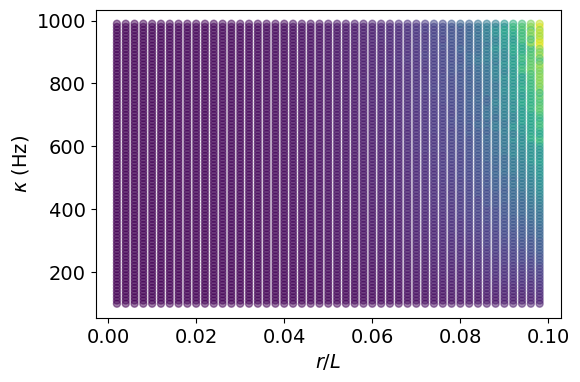

In [567]:
# fig,ax,x,y,z,title,cmap,vmin,vmax,
fontsize=14
cbar_label='Number of Spikes'
fraction=0.07
shrink=0.85
aspect=35
orientation='horizontal'
extend='max'
                            
                            
xlabel=r'$r/L$'
ylabel='$\kappa$ (Hz)'
fontsize=14
kwargs_scatter=dict(s=25,alpha=0.5)

# fig,axs=plt.subplots(ncols=3,figsize=(16,4))
# ax=axs[0]
fig,ax=plt.subplots(ncols=1,figsize=(6,4))
z_values=dh['M']
vmin=np.min(z_values)
vmax=np.max(z_values)
#TODO: make diverging color map

# #TOOD: add colorbar
ax.scatter(x=x_values,y=y_values,c=z_values,**kwargs_scatter)
# format_plot(ax=ax,xlabel=xlabel,ylabel=ylabel,fontsize=fontsize)
# plt.show()


# c = ax.pcolormesh(x_values, y_values, z_values, cmap=cmap, vmin=vmin, vmax=vmax)

# # plot colored grid
# c = ax.pcolormesh(x_values, y_values, z_values, cmap=cmap, vmin=vmin, vmax=vmax,
#                    norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax),shading='auto')
#add formated colorbar
cax, kw = mpl.colorbar.make_axes_gridspec(ax, orientation=orientation,#pad=0.1,
                                       fraction=fraction, shrink=shrink, aspect=aspect)
cbar=fig.colorbar(c, cax=cax, orientation=orientation)#, extend=extend)#, fontsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)
cbar.set_label(label=cbar_label,size=fontsize)
#format_plot
format_plot(ax=ax,xlabel=xlabel,ylabel=ylabel,fontsize=fontsize)
# ax.set_title(title,fontsize=fontsize+2)
# format_plot(ax=ax,xlabel=xlabel,ylabel=ylabel,
#     fontsize=fontsize,**kwargs)
# set the limits of the plot to the limits of the data
# ax.axis([x.min(), x.max(), y.min(), y.max()])
plt.show()

# interpolate the data

In [ ]:
from scipy.interpolate import griddata
grid_z0 = griddata(points, values, (grid_x, grid_y), method='nearest')
grid_z1 = griddata(points, values, (grid_x, grid_y), method='linear')
grid_z2 = griddata(points, values, (grid_x, grid_y), method='cubic')

In [531]:
M=wjr['fk_pbc']['M']
m=wjr['fk_pbc']['m']
# M=wjr['lr_pbc']['M']
# m=wjr['lr_pbc']['m']

# input_fn=f"/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_24_all_powerlaw_fits.csv" #neighbors=1
# input_fn=f"/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_25_all_powerlaw_fits.csv" #neighbors=1
# input_fn=f"/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_17_all_powerlaw_fits.csv" #neighbors=0
# heretim
# input_fn=f"{nb_dir}/data/osg_output/run_17_all_powerlaw_fits.csv"  #Q: does run 17 has great fits? A: yes! #neighbors=0
#lr: 2e-2  #fk: 6e-2

# input_fn=f"{nb_dir}/data/osg_output/run_18_all_powerlaw_fits.csv"
# input_fn=f"{nb_dir}/data/osg_output/run_19_all_powerlaw_fits.csv" #Q: does run 19 has great fits? A: yes! #neighbors=1
# #lr: 1e-2  #fk: 5e-2
#heretim

print(f"{M=:.4f}, {m=:.4f}")
# df=pd.read_csv(input_fn)
# df = comp_rmse_powerlaw(df,M=M,m=m,dq=0.05)
# # df = comp_rmse_powerlaw(df,q_values,M,m,dq=0.05)
# df.sort_values(by='rmse',inplace=True)
# df['rmse'].values

M=5.5723, m=1.8772


In [532]:
# r=0.1
# col_lst=['varkappa','D','r','kappa','rmse']
# # col_lst=['varkappa','D','r','kappa','rmse', 'm', 'M']
# boo = df['r']==r
# print(f"{alinear=}, {D=}")
# print(f"showing settings with {r=}, sorted by rmse")
# # dg=df[boo]
# dg=df#[boo]
# df[boo][col_lst].head(20)

In [477]:
#define parameters to be varied
# input_cols=['r','D','varkappa']#
input_cols=['r','kappa','varkappa','D']#
# output_cols=['m','Delta_m','M','Delta_M']#2 minute runtime
output_cols=['m','M']#2.75 minute runtime paradoxically...
#inputs:dg,input_cols,output_col
#output: fitted model
# dg=df
Xall=dg[input_cols].values 
yall=dg[output_cols].values

In [478]:
X=Xall.copy()
y=yall.copy()
m = len(y) # number of training examples
print(f'number of training examples is {m:d}.')
# print(f"estimated runtime is ~{20+120*int(testing)} seconds...")
print(f"estimated runtime is 2.5 minutes (for 17640 training samples)...")

interp = LinearNDInterpolator(X, y)
# interp = CloughTocher2DInterpolator(X, y)
print(f"training complete!")
if testing:
    yhat = interp(X)
    print(f"shape of X {X.shape} --> shape of y=yhat {yhat.shape}")

    rmse=np.sqrt(np.mean((yhat-y)**2))
    print(f"the rmse of simple interpolation is {rmse:.4f}")
    

number of training examples is 17916.
estimated runtime is 2.5 minutes (for 17640 training samples)...


KeyboardInterrupt: 

# Plot best powerlaw fits of linear to full

In [ ]:
#DONE: recall desired powerlaw fit
# Recall powerlaw fits to full models
wjr=recall_powerlaw_fits_to_full_models()
print(f"options for model_name:")
print(*wjr)

# #select fenton-karma model
# alinear= 1.553 #(16) cm^2/s
# D = 0.114 #(8) cm^2/s
# model_name='fk_pbc'
# c='C0'

#select luo-rudy model
alinear= 9.969 #(100) cm^2/s
D = 0.09 #(50) cm^2/s
model_name='lr_pbc'
c='C1'

print(f"\nthe powerlaw fit for {model_name}:")
dict_fit = wjr[model_name]
print_dict(dict_fit)
m=dict_fit['m']
M=dict_fit['M']

In [ ]:
#compute annihilation rates 
nu_full=wjr[model_name]['m']
M_full=wjr[model_name]['M']
q_values=np.linspace(0.1,1,20)
w_values=M_full*q_values**nu_full

if model_name=='lr_pbc':
    model_name_string='Luo-Rudy Model'
#     model_name_string='Luo-Rudy'
elif model_name=='fk_pbc':
    model_name_string='Fenton-Karma Model'
#     model_name_string='Fenton-Karma'
else:
    model_name_string='??'

In [ ]:
comp_rmse_via_interp

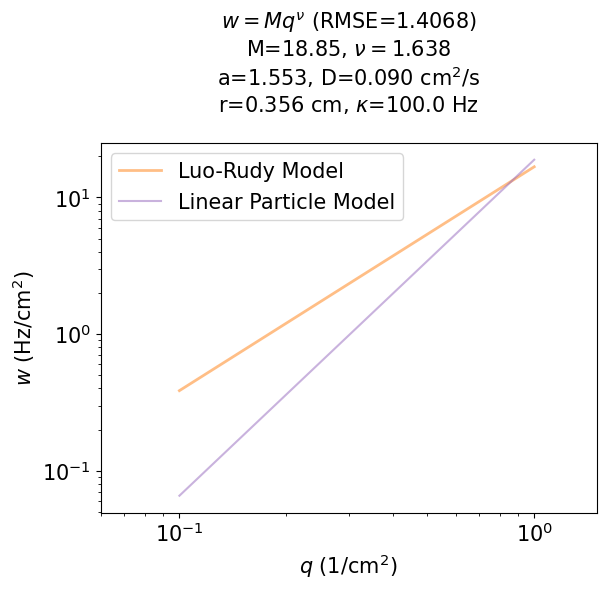

a=1.553, D=0.09, r=0.35576156616210897, kappa=100.0, (RMSE=1.4067983778020983)


In [292]:
#find a best r,kappa pair for a given a,D pair for a given full model
args=a,D,q_values,w_values,interp
bnds = ((1e-3, 2), (1e2, 1e4))
x0 = (.3, 100)
res = minimize(comp_rmse_via_interp, x0, args, method='Nelder-Mead', bounds=bnds,tol=1e-3)
# res = minimize(comp_rmse_via_interp, (0.1, 500), args, method='Nelder-Mead', bounds=bnds,tol=1e-3)
mse=comp_mse_via_interp(res.x, *args)
rmse=np.sqrt(mse)
# rmse=comp_rmse_via_interp(res.x, *args)

#compute the resulting annihilation rates
r=res.x[0]
kappa=res.x[1]
X=np.array([[r,kappa,a,D]])
yhat = interp(X)
nu=yhat[0,0]
M=yhat[0,1]
# M=yhat[0,2]
what_values=M*q_values**nu

#plot the result over the original annihilation rates
use_loglog=True
fontsize=15
# title=f'a={a:.3f}, D={D:.3f}'+r' cm$^2$/s'+f"\nr={r:.3f} cm, "+r'$\kappa$'+f'={kappa:.1f} Hz\nRMSE={rmse:.4f}\n'
title=r"$w=Mq^\nu$"+f" (RMSE={rmse:.4f})\n{M=:.4}, "+r"$\nu=$"+f"{m:.4}\n"
title+=f'a={a:.3f}, D={D:.3f}'+r' cm$^2$/s'+f"\nr={r:.3f} cm, "+r'$\kappa$'+f'={kappa:.1f} Hz\n'
plt.plot(q_values,w_values,c=c,label=model_name_string,alpha=0.5,lw=2)
plt.plot(q_values,what_values,c='C4',label='Linear Particle Model',alpha=0.5)
format_plot(ax=plt.gca(),xlabel=r'$q$ (1/cm$^2$)',ylabel=r'$w$ (Hz/cm$^2$)',use_loglog=use_loglog,fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.title(title,fontsize=fontsize)
plt.xlim([0.06,1.5])
plt.show()
print(f"a={a}, D={D}, r={r}, kappa={kappa}, (RMSE={rmse})")

# plot histogram of powerlaw exponents for the linear particle model with alinear,D fixed to either full model

In [75]:
# fontsize=16
# alpha=0.5
# bins=12
# fig,axs=plt.subplots(ncols=2,figsize=(16,5))
# axs.shape

In [95]:
#extract values from df
name=(1.553, 0.114)  #alinear,D
model_name1='fk_pbc'
color1='C0'
# model_name_string1='Fenton-Karma Model'
model_name_string1=r'Linear Particle with $a_{Lin.,FK}$, $D_{FK}$'
boo = (df['varkappa']==name[0])&(df['D']==name[1])
nu_values1 = df[boo]['m'].values
M_values1 = df[boo]['M'].values
r_values1 = df[boo]['r'].values
kappa_values1 = df[boo]['kappa'].values

name=(9.969, 0.09)  #alinear,D
model_name2='lr_pbc'
color2='C1'
# model_name_string2='Luo-Rudy Model'
model_name_string2=r'Linear Particle with $a_{Lin.,LR}$, $D_{LR}$'
boo = (df['varkappa']==name[0])&(df['D']==name[1])
nu_values2 = df[boo]['m'].values
M_values2 = df[boo]['M'].values
r_values2 = df[boo]['r'].values
kappa_values2 = df[boo]['kappa'].values

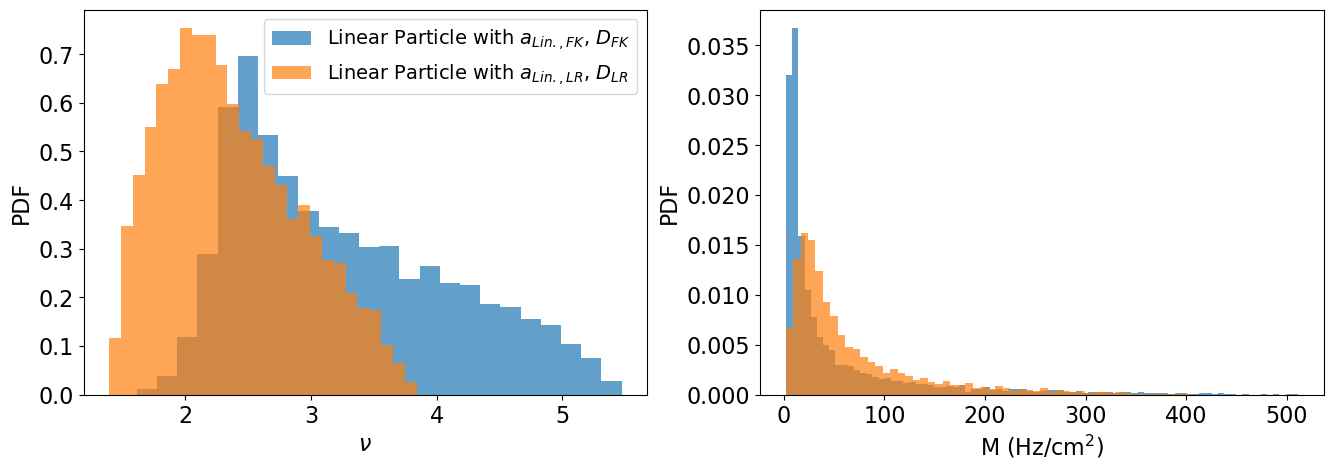

In [98]:
#TODO: plot histogram of powerlaw exponents for the linear particle model with alinear,D fixed to either full model
fontsize=16
alpha=0.7
bins='auto'
# bins=12
fig,axs=plt.subplots(ncols=2,figsize=(16,5))

#plot the fenton-karma model
axs[1].hist(M_values1,bins=bins, alpha=alpha,color=color1,label=model_name_string1,density=True)
axs[0].hist(nu_values1,bins=bins, alpha=alpha,color=color1,label=model_name_string1,density=True)
#plot the luo-rudy model
axs[1].hist(M_values2,bins=bins, alpha=alpha,color=color2,label=model_name_string2,density=True)
axs[0].hist(nu_values2,bins=bins, alpha=alpha,color=color2,label=model_name_string2,density=True)


#format plot
# format_plot(ax=axs[1],xlabel=r'M (Hz/cm$^2$)',ylabel='PDF',fontsize=fontsize,use_loglog=True)        
format_plot(ax=axs[1],xlabel=r'M (Hz/cm$^2$)',ylabel='PDF',fontsize=fontsize,use_loglog=False)        
format_plot(ax=axs[0],xlabel=r'$\nu$',ylabel='PDF',fontsize=fontsize)        
axs[0].legend(fontsize=fontsize-2)
plt.show()

In [99]:


# nah...
# #TODO: fix alinear
# #TODO: plot 

# TODO: visualize the 3D minimum locus of $w(q)$ for the linear particle model fit to the full models
- xyz axis :: r,1/kappa,alinear
- let colours deepen with the square of RMSE

In [449]:
# alinear=1.553 #fk #diffCoeff=0.0005
# D=0.114 #fk #diffCoeff=0.0005
# L=5
# model_name_full='fk_pbc'
# cmap='Blues_r'
# title_str='w(q) fits of linear particle\nmodel to Fenton-Karma model'

alinear=9.969 #lr #diffCoeff=0.001
D=0.09 #lr #diffCoeff=0.001
L=5
model_name_full='lr_pbc'
cmap='Oranges_r'
title_str='w(q) fits of linear particle\nmodel to Luo-Rudy model'

In [450]:
input_fn=f"{nb_dir}/data/osg_output/run_17_all_powerlaw_fits.csv"  #run 17 has great fits
# input_fn=f"{nb_dir}/data/osg_output/run_18_all_powerlaw_fits.csv"
input_fn=f"{nb_dir}/data/osg_output/run_19_all_powerlaw_fits.csv" #Q: does run 19 has great fits?
# input_fn=f"{nb_dir}/data/osg_output/run_20_all_powerlaw_fits.csv"#too low varkappa
# input_fn=f"{nb_dir}/data/osg_output/run_21_all_powerlaw_fits.csv"#too low varkappa
# input_fn=f"{nb_dir}/data/osg_output/run_22_all_powerlaw_fits.csv" #t/'oo low varkappa
# input_fn=f"{nb_dir}/data/osg_output/run_23_all_powerlaw_fits.csv" #too low varkappa
# input_fn=f"{nb_dir}/data/osg_output/run_24_all_powerlaw_fits.csv"
input_fn=f"{nb_dir}/data/osg_output/run_25_all_powerlaw_fits.csv"
df=pd.read_csv(input_fn)

print(f"parameter range:")
print(df.describe()[['varkappa','D','L','r','kappa']].T[['min','max']].T)
print(f"\nalinear values considered: {sorted(df['varkappa'].drop_duplicates().values)} cm^2/s")

# print(f"\n\n(more details:)")
# print(df.describe().T[['min','max']])
df = df[df['model_name_full']==model_name_full].copy()

parameter range:
     varkappa      D    L     r  kappa
min     1.553  0.090  5.0  0.01  100.0
max     9.969  0.114  5.0  0.49  990.0

alinear values considered: [1.553, 9.969] cm^2/s


In [451]:
df.columns

Index(['m', 'Delta_m', 'M', 'Delta_M', 'Rsq', 'rmse', 'rmse_full',
       'model_name_full', 'q_min', 'q_max', 'r', 'kappa', 'D', 'varkappa',
       'x0', 'L', 'force_code', 'neighbor', 'reflect', 'set_second',
       'no_repulsion', 'no_attraction', 'dt', 'Dt'],
      dtype='object')

In [452]:
#extract  values
r_values=df['r'].values
kappa_values=df['kappa'].values
alinear_values=df['varkappa'].values
M_values = df['M'].values
nu_values = df['m'].values
rmse_values = df['rmse_full'].values
# rmse_values = df['rmse'].values #rmse of powerlaw fit to apparent w(q) estimates

In [453]:
num_points=1e2
random_state=42
# temperature_scale=1e2
temperature_scale=1e-3

In [454]:
#TODO: visualize any intrinsic shapes
# df['x']=df['r']/df['L']
# df['y']=df['kappa']
# df['z']=(df['L']**2)/df['varkappa']
df['x']=df['r']/df['L']
df['y']=1/df['kappa']
# df['y']=df['kappa']
df['z']=df['varkappa']/(df['L']**2)
xlabel=r'$r/L$'
ylabel=r'$1/\kappa$ (s)'
# ylabel=r'$\kappa$ (Hz)'
zlabel=r'$a_{Linear}/L^2$ (Hz)'

#input: M,nu,threshold,D

# first, condition interp on D.
# then, with interp: (r,kappa,alinear) --> (M,nu):
#input: M,nu,threshold,interp
x_values=df.x.values#r/L
y_values=df.y.values#1/kappa
z_values=df.z.values#L^2/alinear
c_values=df.rmse.values**2#L^2/alinear
D_values=df.D.values #for reporting

In [455]:
#compute the boltzman distribution generated by mean squared error to the full models
rmse_values=df.rmse.values
p_values = np.exp(-(rmse_values**2)/(temperature_scale))
Z_partition_fun=np.sum(p_values)
p_values/=Z_partition_fun

In [456]:
#randomly select points from the point cloud using ibid
i_values=np.arange(p_values.shape[0])
np.random.seed(random_state)
# i_values_selected=np.random.choice(i_values, size=int(num_points), replace=False, p=p_values)
i_values_selected=np.random.choice(i_values, size=int(num_points), replace=True, p=p_values)
x_values_selected=x_values[i_values_selected]
y_values_selected=y_values[i_values_selected]
z_values_selected=z_values[i_values_selected]
D_values_selected=D_values[i_values_selected]
# c_values_selected=p_values[i_values_selected]
# c_values_selected=np.log(p_values[i_values_selected])
c_values_selected=c_values[i_values_selected]

In [457]:
# DONE: compute c_values interpolated to surface
xlim=[np.min(x_values),np.max(x_values)]
ylim=[np.min(y_values),np.max(y_values)]
zlim=[np.min(z_values),np.max(z_values)]
# xlim=[0.005, 0.05]
# ylim=[0.0006666666666666666, 0.01]
# zlim=[0.01, 1.1]

# xx, yy = np.meshgrid(np.linspace(ylim[0],ylim[1],10),np.linspace(xlim[0],xlim[1],10))
xx, yy = np.meshgrid(np.linspace(xlim[0],xlim[1],10),np.linspace(ylim[0],ylim[1],10))
z_obs = 0.*xx - 0.*yy + alinear/(L**2)

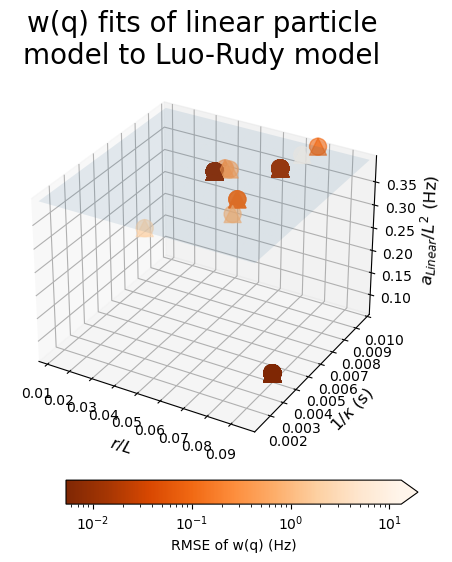

indicated is (shaded plane) alinear=9.969 cm^2/s.


In [458]:
#DONE: plot the point cloud using the simplest possible method from matplotlib
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

#load libraries for color bar
from matplotlib.cm import ScalarMappable
import matplotlib.colors as colors
import matplotlib.cbook as cbook
from matplotlib import cm
#def plotter_3dpoint_cloud_sample(az,...):
fontsize=12
num_samples = 1000
marker='o'
alpha=0.6
markersize=150
# markersize=300
# xlim=[0.005, 0.05]
# ylim=[0.00066, 0.01]
# zlim=[0.01, 1.1]

vmin=None
vmax=None
#create a continuous norm to map from data points to colors
if vmin is None:
    vmin=c_values.min()
if vmax is None:
    vmax=c_values.max()
norm = plt.Normalize(vmin, vmax)

# ax.set_title(title_str,fontsize=fontsize)
ax.set_title(title_str,fontsize=fontsize+8)
# cmap='viridis'
# ax.scatter(x_values,y_values,z_values,marker=marker,alpha=alpha,s=markersize,cmap=cmap,c=c_values)
ax.scatter(x_values_selected,y_values_selected,z_values_selected,
           c=c_values_selected,
           marker=marker,alpha=alpha,s=markersize,cmap=cmap)

booD=D_values_selected>0
ax.scatter(x_values_selected[booD],y_values_selected[booD],z_values_selected[booD],
           c=c_values_selected[booD],
           marker='^',alpha=alpha,s=markersize,cmap=cmap)


# N = 100
# X, Y = np.mgrid[-3:3:complex(0, N), -2:2:complex(0, N)]
# # A low hump with a spike coming out of the top right.  Needs to have
# # z/colour axis on a log scale so we see both hump and spike.  linear
# # scale only shows the spike.
# Z1 = np.exp(-X**2 - Y**2)
# Z2 = np.exp(-(X * 10)**2 - (Y * 10)**2)
# Z = Z1 + 50 * Z2

# # fig, ax = plt.subplots(2, 1)
norm=colors.LogNorm(vmin=vmin, vmax=vmax)
# pcm = ax[0].pcolor(X, Y, Z,
#                    norm=colors.LogNorm(vmin=Z.min(), vmax=Z.max()),
#                    cmap='PuBu_r', shading='auto')
# fig.colorbar(pcm, ax=ax[0], extend='max')


#plot color bar
# fig.colorbar(ScalarMappable(norm=norm, cmap=cmap), ax=ax)
# cmap='PuBu_r'
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
#vertical color bar
# # cax = plt.axes([0.85, 0.1, 0.075, 0.8])
# cax = plt.axes([0.85, 0.2, 0.025, 0.65])
# plt.colorbar(ScalarMappable(norm=norm, cmap=cmap),cax=cax,label='RMSE of w(q) (Hz)',extend='max')
#horizontal color bar
w=.3
h=.25
cax = plt.axes([0.25, 0, 0.25+w, -0.2+h])
plt.colorbar(ScalarMappable(norm=norm, cmap=cmap),cax=cax,label='RMSE of w(q) (Hz)',extend='max',
            orientation="horizontal", pad=0.)#,textsize=fontsize)#,

# plot the plane of fixed alinear
# TODO: color plane by c_values interpolated to surface
ax.plot_surface(xx, yy, z_obs, alpha=0.1)


#format_plot
ax.set_xlabel(xlabel,fontsize=fontsize)
ax.set_ylabel(ylabel,fontsize=fontsize)
ax.set_zlabel(zlabel,fontsize=fontsize)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_zlim(zlim)
plt.show()
print(f"indicated is (shaded plane) {alinear=} cm^2/s.")

True

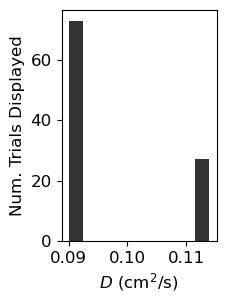

In [459]:
fig,ax=plt.subplots(figsize=(2,3))
plt.hist(D_values_selected,color='black',alpha=0.8)
format_plot(ax=plt.gca(),xlabel=f'$D$ (cm$^2$/s)',ylabel='Num. Trials Displayed',fontsize=fontsize)


In [404]:
D_values_selected

array([0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0.3, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.2, 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1, 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ])

let
- $x=r/L$
- $y=1/\kappa$
- $z=a_\text{Linear}/L^2$
plot
- $c=$rmse for pairwise (M,$\nu$) fits (using q_values=np.arange(0.2,0.7,0.02))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


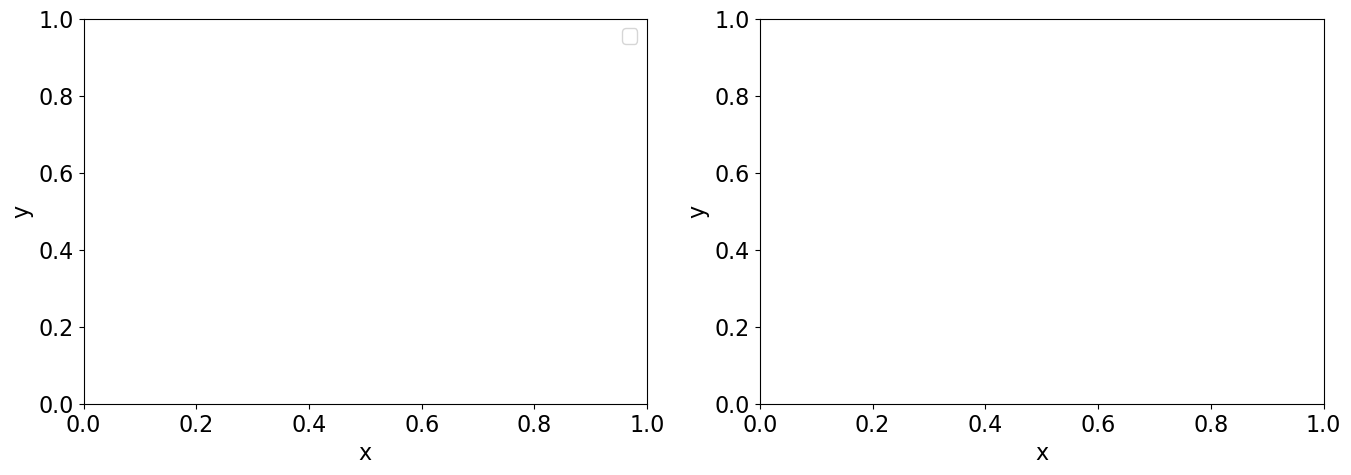

In [150]:
#TODO: plot histogram of powerlaw exponents for the linear particle model with alinear,D fixed to either full model
fontsize=16
alpha=0.7
bins='auto'
# bins=12
fig,axs=plt.subplots(ncols=2,figsize=(16,5))
# #plot the fenton-karma model
# axs[1].hist(M_values1,bins=bins, alpha=alpha,color=color1,label=model_name_string1,density=True)




# #plot the fenton-karma model
# axs[1].hist(M_values1,bins=bins, alpha=alpha,color=color1,label=model_name_string1,density=True)
# axs[0].hist(nu_values1,bins=bins, alpha=alpha,color=color1,label=model_name_string1,density=True)
# #plot the luo-rudy model
# axs[1].hist(M_values2,bins=bins, alpha=alpha,color=color2,label=model_name_string2,density=True)
# axs[0].hist(nu_values2,bins=bins, alpha=alpha,color=color2,label=model_name_string2,density=True)


# xlabel=r'M (Hz/cm$^2$)'
# ylabel='PDF'
xlabel=r'x'
ylabel='y'
zlabel='z'

#format plot
# format_plot(ax=axs[1],xlabel=r'M (Hz/cm$^2$)',ylabel='PDF',fontsize=fontsize,use_loglog=True)        
format_plot(ax=axs[1],xlabel=xlabel,ylabel=ylabel,fontsize=fontsize,use_loglog=False)        
format_plot(ax=axs[0],xlabel=xlabel,ylabel=ylabel,fontsize=fontsize)        
axs[0].legend(fontsize=fontsize-2)
plt.show()

##### recall_particle_model_interp?

In [443]:
recall_particle_model_interp(
    reflect=0,
    force_code=2,
    set_second=0,
    no_attraction=0,
    no_repulsion=0,
    L=10,
    testing=False,
    printing=True,
    mode='vectorsummed',
    input_fn_dict=None,
    **kwargs)

In [128]:
interp=recall_particle_model_interp()
type(interp)
# ['r','kappa','varkappa','D'] to w(q)

estimated runtime is ~20 seconds for 17988 training samples...
number of training examples is 17988....
training complete!


scipy.interpolate.interpnd.LinearNDInterpolator

In [ ]:
M=19.615561416292167
nu=3.024049156321602
q_values=np.arange(0.2,0.7,0.02)

In [133]:
#DONE: compute testing w(q)
Mhat,nuhat=interp(0.1,500,1.12,0.365)#fk#200x200#diffcoeff=0.001
Mhat,nuhat

(2.213146713833428, 7.336003372380249)

In [134]:
# #TODO: compute interp
# # then, with interp: (r,kappa,alinear) --> (M,nu) with D fixed
# # interp?
# interp=

SyntaxError: invalid syntax (189749657.py, line 4)

In [123]:
# def interp_foo(r,kappa,alinear,interp,**kwargs):
#     Mhat,nuhat=interp(r,kappa,alinear,D)
#     return interp(r,kappa,alinear)

In [136]:
#TODO: visualize any intrinsic shapes
df['x']=df['r']/df['L']
df['y']=df['kappa']
df['z']=(df['L']**2)/df['varkappa']
#input: M,nu,threshold,D

# first, condition interp on D.
# then, with interp: (r,kappa,alinear) --> (M,nu):
#input: M,nu,threshold,interp
x_values=df.x.values#r/L
y_values=df.y.values#1/kappa
z_values=df.z.values#L^2/alinear
r_values=df['r'].values
kappa_values=df['kappa'].values
alinear_values=df['varkappa'].values


In [141]:
# Mhat,nuhat=np.vectorize(interp)(r_values,kappa_values,alinear_values,D)
# Mhat,nuhat=np.vectorize(interp)(r_values,kappa_values,alinear_values,D)
print(f"{D=:.4f}")
Mhat,nuhat=interp(r_values[0],kappa_values[0],alinear_values[0],D)
Mhat,nuhat

# rv=interp(r_values[0],kappa_values[0],alinear_values[0],D)
# rv

D=0.0900


(1.6875364351792497, 54.40141520604243)

In [ ]:
#IDIOTA!: no interp is necessary as M,nu was measured directly from the cloud!
#HERETIM

# TODO: plot rates

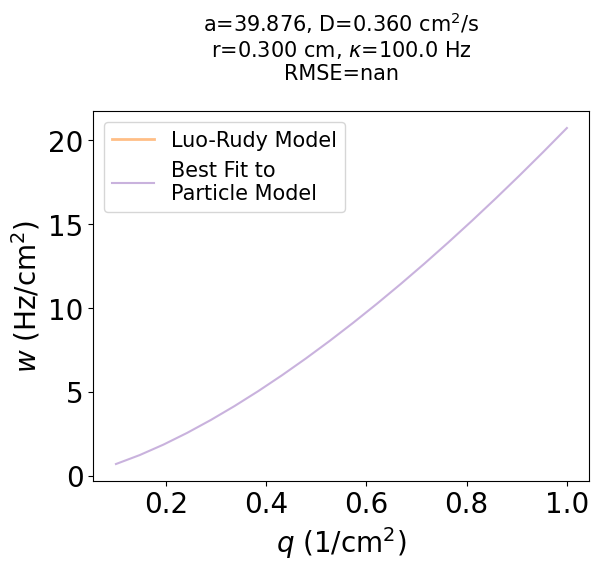

a=39.876, D=0.36, r=0.3, kappa=100.0, rmse=nan


In [446]:
#DONE: plotted how bad the fits are if LR gets alinear~3 instead of alinear~10
# a=a_hat_LR_long
# # a=a_hat_LR
# D=D_hat_LR

# #from fit to wj's FK positions (200x200, diffcoeff: 0.0005)
# a=1.553
# D=0.114

#from fit to wj's LR positions (200x200, diffcoeff: 0.001)
a=9.969*4
D=0.09*4



# Mhat,nuhat=interp_foo(r=df['r'].values,
#                   kappa=df['kappa'].values,
#                   alinear=df['varkappa'].values,
#                       interp=interp)
# Mhat,nuhat=interp(r,kappa,alinear,D)
w_values=M*(q_values**nu)
what_values=Mhat*(q_values**nuhat)
mse_full= (w_values-what_values)**2
c_values=np.sqrt(mse_full)#rmse to full for M,nu given

#outputs: colored 3D scatter plot with associated colorbar (in the basis of (r,1/kappa,alinear)).



#find a best r,kappa pair for a given a,D pair for a given full model
args=a,D,q_values,w_values,interp
# bnds = ((1e-3*4, 2), (1e2*4, 1e4))
bnds = ((1e-3, 2), (1e2, 1e4))
# x0 = (0.1, 500)
# x0 = (.2, 100)
# x0 = (.3, 100)
x0 = (.3, 100)
# x0 = (.3*4, 100)

res = minimize(comp_rmse_via_interp, x0, args, method='Nelder-Mead', bounds=bnds,tol=1e-3)
# res = minimize(comp_rmse_via_interp, (0.1, 500), args, method='Nelder-Mead', bounds=bnds,tol=1e-3)
mse=comp_mse_via_interp(res.x, *args)
rmse=np.sqrt(mse)
# rmse=comp_rmse_via_interp(res.x, *args)

#compute the resulting annihilation rates
r=res.x[0]
kappa=res.x[1]
X=np.array([[r,kappa,a,D]])
yhat = interp(X)
nu=yhat[0,0]
M=yhat[0,1]
# M=yhat[0,2]
what_values=M*q_values**nu

#plot the result over the original annihilation rates
title=f'a={a:.3f}, D={D:.3f}'+r' cm$^2$/s'+f"\nr={r:.3f} cm, "+r'$\kappa$'+f'={kappa:.1f} Hz\nRMSE={rmse:.4f}\n'
plt.plot(q_values,w_values,c=c,label=model_name_string,alpha=0.5,lw=2)
plt.plot(q_values,what_values,c='C4',label='Best Fit to\nParticle Model',alpha=0.5)
format_plot(ax=plt.gca(),xlabel=r'$q$ (1/cm$^2$)',ylabel=r'$w$ (Hz/cm$^2$)')
plt.legend(fontsize=15)
plt.title(title,fontsize=15)
# plt.xscale('log')
# plt.yscale('log')
plt.show()
print(f"a={a}, D={D}, r={r}, kappa={kappa}, rmse={rmse}")

In [447]:
# df.L

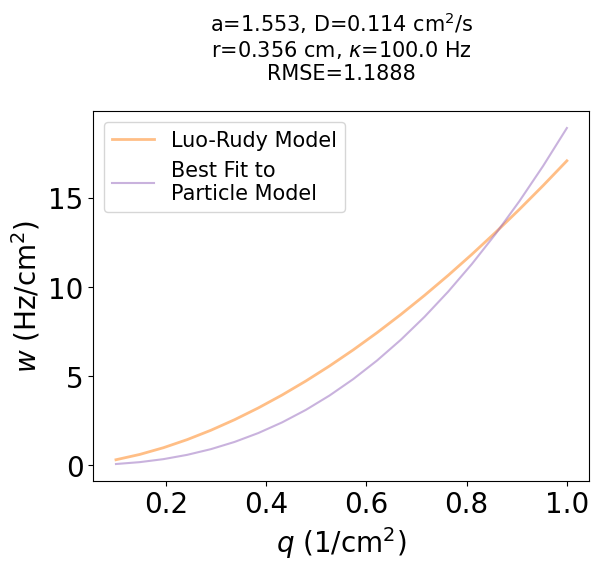

a=1.553, D=0.114, r=0.35641995906829826, kappa=100.0, rmse=1.1887947070569018


In [440]:
#DONE: plotted how bad the fits are if LR gets alinear~3 instead of alinear~10
# a=a_hat_LR_long
# # a=a_hat_LR
# D=D_hat_LR

#from fit to wj's FK positions (200x200, diffcoeff: 0.0005)
a=1.553
D=0.114

# #from fit to wj's LR positions (200x200, diffcoeff: 0.001)
# a=9.969
# D=0.09



# Mhat,nuhat=interp_foo(r=df['r'].values,
#                   kappa=df['kappa'].values,
#                   alinear=df['varkappa'].values,
#                       interp=interp)
# Mhat,nuhat=interp(r,kappa,alinear,D)
w_values=M*(q_values**nu)
what_values=Mhat*(q_values**nuhat)
mse_full= (w_values-what_values)**2
# c_values=np.sqrt(mse_full)#rmse to full for M,nu given

#outputs: colored 3D scatter plot with associated colorbar (in the basis of (r,1/kappa,alinear)).
#find a best r,kappa pair for a given a,D pair for a given full model
args=a,D,q_values,w_values,interp
bnds = ((1e-3, 2), (1e2, 1e4))
# x0 = (0.1, 500)
# x0 = (.2, 100)
# x0 = (.3, 100)
x0 = (.3, 100)
res = minimize(comp_rmse_via_interp, x0, args, method='Nelder-Mead', bounds=bnds,tol=1e-3)
# res = minimize(comp_rmse_via_interp, (0.1, 500), args, method='Nelder-Mead', bounds=bnds,tol=1e-3)
mse=comp_mse_via_interp(res.x, *args)
rmse=np.sqrt(mse)
# rmse=comp_rmse_via_interp(res.x, *args)

#compute the resulting annihilation rates
r=res.x[0]
kappa=res.x[1]
X=np.array([[r,kappa,a,D]])
yhat = interp(X)
nu=yhat[0,0]
M=yhat[0,1]
# M=yhat[0,2]
what_values=M*q_values**nu

#plot the result over the original annihilation rates
title=f'a={a:.3f}, D={D:.3f}'+r' cm$^2$/s'+f"\nr={r:.3f} cm, "+r'$\kappa$'+f'={kappa:.1f} Hz\nRMSE={rmse:.4f}\n'
plt.plot(q_values,w_values,c=c,label=model_name_string,alpha=0.5,lw=2)
plt.plot(q_values,what_values,c='C4',label='Best Fit to\nParticle Model',alpha=0.5)
format_plot(ax=plt.gca(),xlabel=r'$q$ (1/cm$^2$)',ylabel=r'$w$ (Hz/cm$^2$)')
plt.legend(fontsize=15)
plt.title(title,fontsize=15)
# plt.xscale('log')
# plt.yscale('log')
plt.show()
print(f"a={a}, D={D}, r={r}, kappa={kappa}, rmse={rmse}")

# dev

In [488]:
from isosurfaces import plot_isoline,plot_isosurface
import numpy as np

# def f(x, y):
#     return y * (x - y) ** 2 - 4 * x - 8

# curves = plot_isoline(
#     lambda u: f(u[0], u[1]),
#     np.array([-8, -6]),
#     np.array([8, 6]),
#     # Increasing min_depth can help if you have small features
#     min_depth=3,
#     # Ensure max_quads is more than 4**min_depth to capture details better
#     # than a 2**min_depth by 2**min_depth uniform grid
#     max_quads=1000,
# )

# for curve in curves:
#     print(', '.join(f"({p[0]:.3f},{p[1]:.3f})" for p in curve))

In [489]:
metaball_pts = [np.array([0, 1.6, 0]), np.array([0, -1.6, 0])]

def fn(p):
    # metaballs
    # return sum(1 / np.linalg.norm(p - q) for q in metaball_pts) - 1
    # cone with singularity at origin
    return p[0] ** 2 + p[1] ** 2 - p[2] ** 2

pmin = np.array([-4, -4, -4])
pmax = np.array([4, 4, 4])
simplices, faces = plot_isosurface(fn, pmin, pmax, 2, 64)
# faces = list(faces)

In [491]:
for v in simplices[0]:
    print(v)

(-3.0,-3.0; 9.0)
(-4.0,-3.0; 16.0)
(-4.0,-4.0; 23.0)
(-4.0,-4.0; 16.0)


In [505]:
for v in simplices[1]:
    print(v)

(-3.0,-3.0; 9.0)
(-4.0,-3.0; 16.0)
(-4.0,-4.0; 23.0)
(-4.0,-4.0; 28.0)


In [492]:
simplices[0]

[(-3.0,-3.0; 9.0), (-4.0,-3.0; 16.0), (-4.0,-4.0; 23.0), (-4.0,-4.0; 16.0)]

In [501]:
vertices_set={}
for face in faces:
    pass

In [503]:
import matplotlib.tri as mtri

In [504]:
mtri.Triangulation?

In [502]:
face

[array([3.  , 2.25, 3.75]),
 array([3.        , 2.64574871, 4.        ]),
 array([3.46409949, 2.        , 4.        ])]

In [498]:
type(simplices[0][0])

isosurfaces.point.ValuedPoint

In [500]:
simplices[0][0]

(-3.0,-3.0; 9.0)

In [ ]:
mtri.Triangulation(x, y)